In [3]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

from typing import Union, List
from diffSPH.kernels import getKernel
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import volumeToSupport

from diffSPH.v2.math import mod
from torchCompactRadius import radiusSearch
from torchCompactRadius.util import countUniqueEntries

from diffSPH.v2.sampling import sampleRegular
from torchCompactRadius import radiusSearch
from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import mod, volumeToSupport
from diffSPH.kernels import getKernel
from diffSPH.v2.neighborhood import neighborSearch
from diffSPH.v2.sampling import samplePDF
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.shifting import computeShifting
import numpy as np
import torch

from diffSPH.v2.finiteDifference import computeGradient
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
    pos = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
    sc = axis.scatter(pos[:,0], pos[:,1], s = 8, c = c)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    if p.shape[1] > 1:
        square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        axis.add_patch(square)
    axis.set_aspect('equal')
    axis.set_xlim(domainMin[0] * 1.05, domainMax[0] * 1.05)
    axis.set_ylim(domainMin[1] * 1.05, domainMax[1] * 1.05)

def scatterPlotSymmetric(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
    pos_x = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
    # pos_y = torch.stack([y[:,i] if not periodic_i else torch.remainder(y[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

    sc = axis.scatter(pos_x[:,0], pos_x[:,1], s = 8, c = c, vmin = -c.abs().max(), vmax = c.abs().max(), cmap = 'Spectral')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    if p.shape[1] > 1:
        square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        axis.add_patch(square)
    axis.set_aspect('equal')
    axis.set_xlim(-1.05,1.05)
    axis.set_ylim(-1.05,1.05)

In [4]:
minExtent = -1
maxExtent = 1
nx = 64
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland2')
periodic = True
dim = 2
volume = dx**dim
h = volumeToSupport(volume, targetNeighbors, dim)

domainMin = torch.tensor([minExtent]* dim, dtype = torch.float32)
domainMax = torch.tensor([maxExtent]* dim, dtype = torch.float32)

pInitial, volume = sampleRegular(dx, dim, minExtent, domainMax, targetNeighbors, True, k)
areas = pInitial.new_ones(pInitial.shape[0]) * volume
ones = pInitial.new_ones(pInitial.shape[0])
supports = pInitial.new_ones(pInitial.shape[0]) * h

In [5]:

def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
    s = 5000 / p.shape[0]
    pos = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
    sc = axis.scatter(pos[:,0], pos[:,1], s = s, c = c)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    if p.shape[1] > 1:
        square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        axis.add_patch(square)
    axis.set_aspect('equal')
    axis.set_xlim(domainMin[0] * 1.05, domainMax[0] * 1.05)
    axis.set_ylim(domainMin[1] * 1.05, domainMax[1] * 1.05)

def scatterPlotSymmetric(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
    s = 5000 / p.shape[0]
    pos_x = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
    # pos_y = torch.stack([y[:,i] if not periodic_i else torch.remainder(y[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

    sc = axis.scatter(pos_x[:,0], pos_x[:,1], s = s, c = c, vmin = -c.abs().max(), vmax = c.abs().max(), cmap = 'coolwarm')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    if p.shape[1] > 1:
        square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        axis.add_patch(square)
    axis.set_aspect('equal')
    axis.set_xlim(-1.05,1.05)
    axis.set_ylim(-1.05,1.05)

Given a kernel:
$$ W(x_i - x_j, y_i - y_j, h) = C_d h^{-d} f\left(\frac{\sqrt{\left(x_i - x_j\right)^2 + \left(y_i -y_j\right)^2}}{h}\right)$$

For convenience denote $q_{ij} = \frac{\sqrt{\left(x_i - x_j\right)^2 + \left(y_i -y_j\right)^2}}{h}$ and $r_{ij} = \sqrt{\left(x_i - x_j\right)^2 + \left(y_i -y_j\right)^2}$

We need the first derivatives w.r.t. x_j and y_j, i.e., $ \frac{\partial W}{\partial x_j}$ and $\frac{\partial W}{\partial y_j}$. Using [Wolfram](https://www.wolframalpha.com/input?i=d%2Fdx+f%28%5Csqrt%28%28a-x%29%5E2+%2B+%28b-y%29%5E2%29%2Fh%29) we get:

$$ \frac{\partial W}{\partial x_j} = \frac{x_i - x_j}{r_{ij}} C_d h^{-(d+1)} f^\prime(q_{ij}) $$
and
$$ \frac{\partial W}{\partial x_j} = \frac{y_i - y_j}{r_{ij}} C_d h^{-(d+1)} f^\prime(q_{ij}) $$



For the second derivatives we get more complex terms for $\frac{\partial^2}{\partial x^2}$ ([Wolfram](https://www.wolframalpha.com/input?i=d%5E2%2F%28dx%5E2%29+f%28%5Csqrt%28%28a-x%29%5E2+%2B+%28b-y%29%5E2%29%2Fh%29)):

$$ \frac{\partial^2}{\partial x^2} W = C_d h^{-d} \cdot \left[
    \frac{\left(x_i - x_j\right)^2}{h^2 r_{ij}^2} f^{\prime\prime}(q_{ij}) +\left(\frac{1}{h r_{ij}} - \frac{\left(x_i - x_j\right)^2}{h r_{ij}^{3}}\right)f^\prime(q_{ij}) \right]
$$



And for the diagonal terms: [Wolfram](https://www.wolframalpha.com/input?i=d%5E2%2F%28dxdy%29+f%28%5Csqrt%28%28a-x%29%5E2+%2B+%28b-y%29%5E2%29%2Fh%29):

$$\frac{\partial^2}{\partial x\partial y} W = C_d h^{-d} \frac{\left(x_i - x_j\right)\left(y_i - y_j\right)}{h r_{ij}^2} \cdot \left[ \frac{1}{h} f^{\prime\prime}(q_{ij}) - \frac{1}{r_{ij}} f^\prime(q_{ij})\right]$$

In [6]:
p = torch.clone(pInitial) + torch.normal(0, 0.35 * h, pInitial.shape)
p2 = torch.clone(p)


In [7]:
from diffSPH.v2.shifting import evalKernel

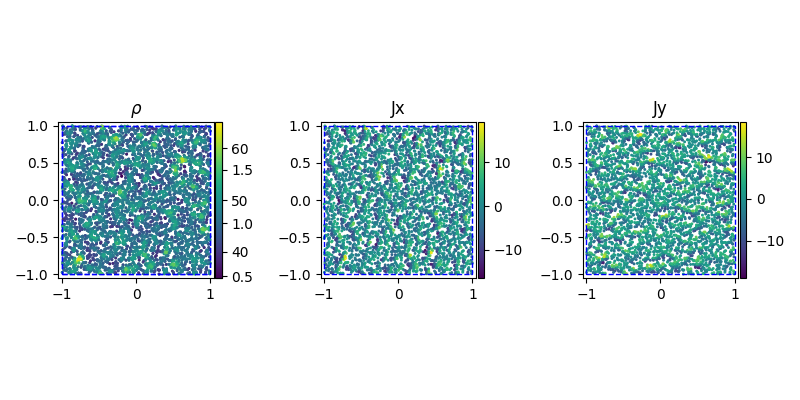

In [8]:
fig, axis = plt.subplots(1, 3, figsize=(8,4), sharex = False, sharey = False, squeeze = False)

areas = p.new_ones(p.shape[0]) * volume
ones = p.new_ones(p.shape[0])
supports = p.new_ones(p.shape[0]) * h


i, j, rij, xij, hij, Wij, gradWij = neighborSearch(p, p, h, h, kernel = k, dim = dim, periodic = periodic, minDomain = domainMin, maxDomain = domainMax)
ii, ni = countUniqueEntries(i, p)

numParticles = p.shape[0]
K, J, H = evalKernel(rij, xij, hij, k, dim)
omega = areas

J = scatter_sum(J * omega[j,None], i, dim = 0, dim_size = numParticles)

scatterPlot(fig, axis[0,0], p, ni, domainMin, domainMax, 'Number of Neighbors[ni]')
rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')

scatterPlot(fig, axis[0,0], p, rho, domainMin, domainMax, '$\\rho$')
scatterPlot(fig, axis[0,1], p, J[:,0], domainMin, domainMax, 'Jx')
scatterPlot(fig, axis[0,2], p, J[:,1], domainMin, domainMax, 'Jy')

fig.tight_layout()

In [9]:

for i in (t:= tqdm(range(64))):        
    update, J, B, H = computeShifting(p, areas, h, k, dim, periodic, domainMin, domainMax, periodic)

    t.set_description(f'J: {J.abs().max()}')
    dx = update[:,0]
    dy = update[:,1]

    update = torch.clamp(update, -0.5 * h, 0.5 * h)
    p = p + update

    if J.abs().max() < 1e-2:
        break


  0%|          | 0/64 [00:00<?, ?it/s]

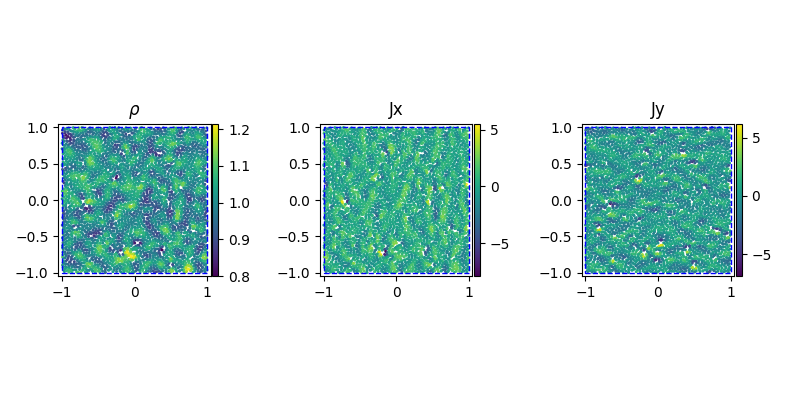

In [10]:
fig, axis = plt.subplots(1, 3, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
i, j, rij, xij, hij, Wij, gradWij = neighborSearch(p, p, h, h, kernel = k, dim = dim, periodic = periodic, minDomain = domainMin, maxDomain = domainMax)
ii, ni = countUniqueEntries(i, p)

numParticles = p.shape[0]
K, J, H = evalKernel(rij, xij, hij, k, dim)
omega = areas

J = scatter_sum(J * omega[j,None], i, dim = 0, dim_size = numParticles)

# scatterPlot(fig, axis[0,0], p, ni, domainMin, domainMax, 'Number of Neighbors[ni]')
rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')

scatterPlot(fig, axis[0,0], p, rho, domainMin, domainMax, '$\\rho$')
scatterPlot(fig, axis[0,1], p, J[:,0], domainMin, domainMax, 'Jx')
scatterPlot(fig, axis[0,2], p, J[:,1], domainMin, domainMax, 'Jy')

fig.tight_layout()

# fig, axis = plt.subplots(1, 3, figsize=(8,4), sharex = False, sharey = False, squeeze = False)

# scatterPlotSymmetric(fig, axis[0,0], p, dx, domainMin, domainMax, 'Sum of Kernel')
# scatterPlotSymmetric(fig, axis[0,1], p, dy, domainMin, domainMax, 'Sum of Kernel')
# scatterPlot(fig, axis[0,2], p2, torch.linalg.norm(p2-2, dim = -1), domainMin, domainMax, 'Distance')
# fig.tight_layout()

In [11]:
from diffSPH.v2.surfaceDetection import *
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
def plotSDF(fx, X, Y, extent, dim, ngrid = 255):
    fig, axis = plt.subplots(1, 3, figsize=(14,4), sharex = False, sharey = False, squeeze = False)

    fx = fx.reshape(ngrid, ngrid)
    output = computeGradient(fx, extent, dim, 1)
    # Plot the isocontours of fx
    axis[0,0].contour(X.numpy(), Y.numpy(), fx.numpy(), levels=[0], colors='black')


    # sdfValues = sdCircle(P, 1.0)
    # sdfGradient = gradient(sdfValues, 4, 1, 2)
    # sdfGradient = torch.stack([centralDifference(sdfValues, 1/ngrid, 1, 4), centralDifference(sdfValues, 1/ngrid, 1, 4)], axis=-1)
    # sdfValues = fx
    # sdfGradient = output
    # print(sdfGradient.shape)

    im = axis[0,0].pcolormesh(X.numpy(), Y.numpy(), fx.numpy(), cmap='Spectral',vmin = - torch.max(torch.abs(fx)).numpy(), vmax = torch.max(torch.abs(fx)).numpy())
    axis[0,0].set_title("SDF")
    axis[0,0].set_aspect('equal', 'box')
    divider = make_axes_locatable(axis[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    spacing = 16
    axis[0,0].quiver(X[::spacing,::spacing].numpy(), Y[::spacing,::spacing].numpy(), output[::spacing,::spacing,0].numpy(), output[::spacing,::spacing,1].numpy())

    im = axis[0,1].pcolormesh(X.numpy(), Y.numpy(), output[:,:,0].numpy(), cmap='viridis')
    axis[0,1].set_title("SDF Gradient X")
    axis[0,1].set_aspect('equal', 'box')
    divider = make_axes_locatable(axis[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im = axis[0,2].pcolormesh(X.numpy(), Y.numpy(), output[:,:,1].numpy(), cmap='viridis')
    axis[0,2].set_title("SDF Gradient Y")
    axis[0,2].set_aspect('equal', 'box')
    divider = make_axes_locatable(axis[0,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    # im = axis[0,3].imshow(torch.linalg.norm(output[:,:], dim = -1), extent=(-2, 2, -2, 2), origin='lower', cmap='inferno')
    # axis[0,3].set_title("SDF Gradient Magnitude")
    # divider = make_axes_locatable(axis[0,3])
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(im, cax=cax, orientation='vertical')
    # axis[0,3].set_title("SDF Gradient")
    # axis[0,3].set_aspect('equal', 'box')
    # axis[0,3].set_xlim(-2, 2)
    # axis[0,3].set_ylim(-2, 2)

    fig.tight_layout()

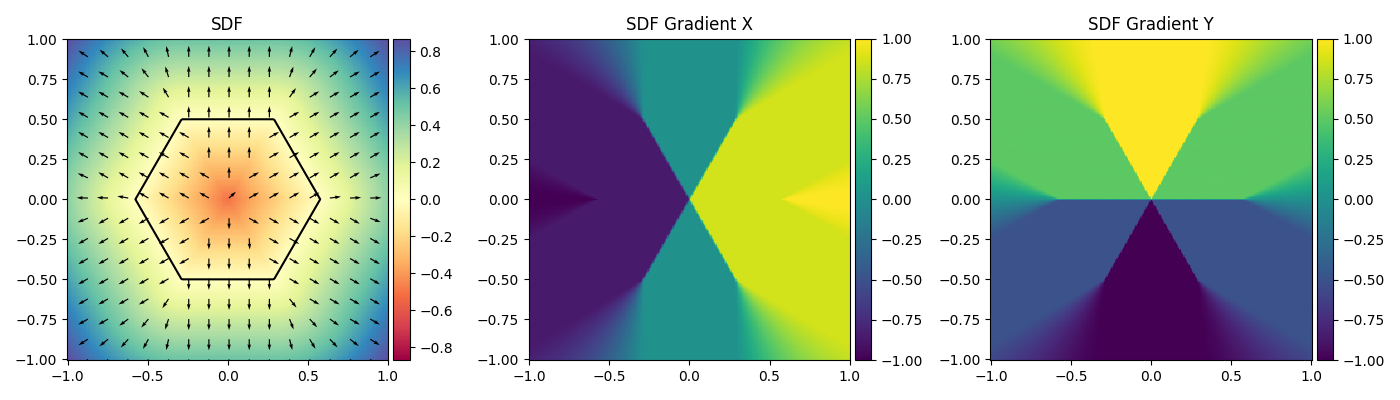

In [12]:


ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)
sdf = sphere_a
# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [13]:
from diffSPH.v2.sampling import filterParticlesWithSDF

In [14]:
minExtent = -1
maxExtent = 1
nx = 64
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland2')
periodic = True
dim = 2
volume = dx**dim
h = volumeToSupport(volume, targetNeighbors, dim)

domainMin = torch.tensor([minExtent]* dim, dtype = torch.float32)
domainMax = torch.tensor([maxExtent]* dim, dtype = torch.float32)

pInitial, volume = sampleRegular(dx, dim, minExtent, domainMax, targetNeighbors, True, k)
areas = pInitial.new_ones(pInitial.shape[0]) * volume
ones = pInitial.new_ones(pInitial.shape[0])
supports = pInitial.new_ones(pInitial.shape[0]) * h

tensor(0.0010, dtype=torch.float64)


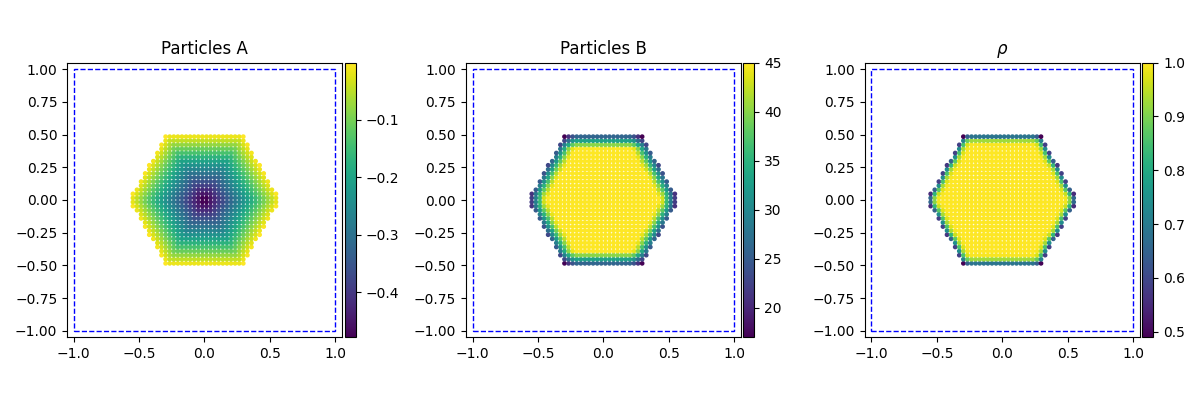

In [15]:
factor = 1
particlesB, volumeB = sampleRegular(dx / factor, dim, minExtent, domainMax, targetNeighbors, True, k)
print(volumeB)
hB = volumeToSupport(volumeB, targetNeighbors, dim)
areasB = particlesB.new_ones(particlesB.shape[0]) * volumeB
onesB = particlesB.new_ones(particlesB.shape[0])
supportsB = particlesB.new_ones(particlesB.shape[0]) * hB

particles, maskB, distance, *_ = filterParticlesWithSDF(particlesB, sdf, h, 0)
areas = areasB[maskB]
ones = onesB[maskB]
supports = supportsB[maskB]
numParticles = particles.shape[0]

i, j, rij, xij, hij, Wij, gradWij = neighborSearch(particles, particles, supports, supports, kernel = k, dim = dim, periodic = True, minDomain = domainMin, maxDomain = domainMax)
ii, ni = countUniqueEntries(i, particles)



fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], particles, distance, domainMin, domainMax, 'Particles A')
scatterPlot(fig, axis[0,1], particles, ni, domainMin, domainMax, 'Particles B')

rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, particles.shape[0], operation = 'interpolate')
scatterPlot(fig, axis[0,2], particles, rho, domainMin, domainMax, '$\\rho$')

fig.tight_layout()

In [164]:
pNoisy = torch.clone(particles) + torch.normal(0, 0.1 * h, particles.shape) * torch.clamp(torch.abs(distance[:,None]) / h, 0, 1)

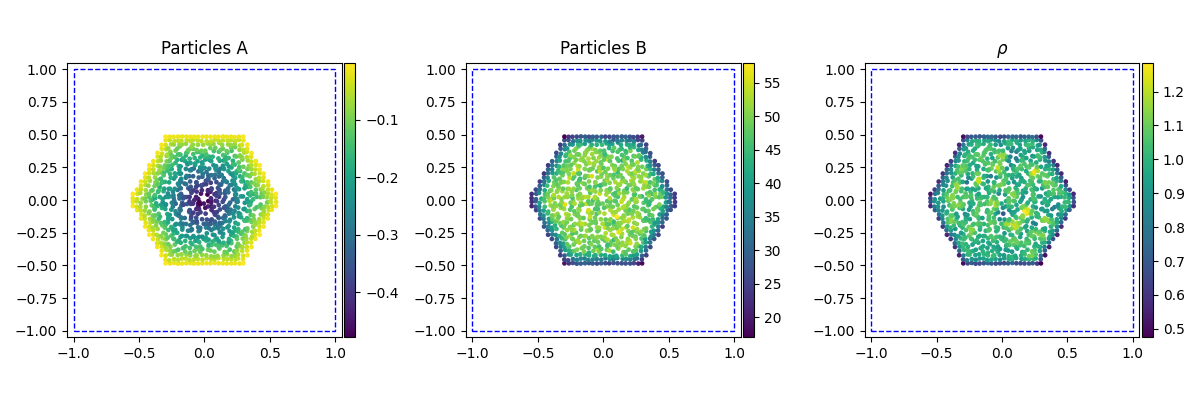

In [165]:

i, j, rij, xij, hij, Wij, gradWij = neighborSearch(pNoisy, pNoisy, supports, supports, kernel = k, dim = dim, periodic = True, minDomain = domainMin, maxDomain = domainMax)
ii, ni = countUniqueEntries(i, particles)


fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], pNoisy, distance, domainMin, domainMax, 'Particles A')
scatterPlot(fig, axis[0,1], pNoisy, ni, domainMin, domainMax, 'Particles B')

rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, particles.shape[0], operation = 'interpolate')
scatterPlot(fig, axis[0,2], pNoisy, rho, domainMin, domainMax, '$\\rho$')

fig.tight_layout()

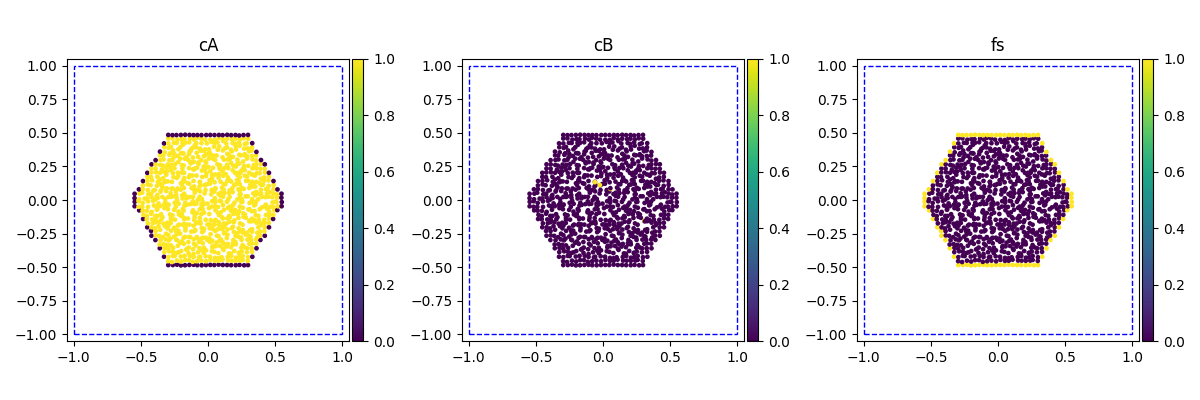

In [166]:
L, normalizationMatrices, lambdas = computeNormalizationMatrices(pNoisy, areas, rho, i, j, Wij, gradWij, rij, xij, hij, numParticles)
n, lMin = computeNormals(pNoisy, lambdas, areas, ones, rho, i, j, Wij, gradWij, xij, rij, hij, particles.shape[0], L)
fs, cA, cB = detectFreeSurfaceMaronne(n, i, j, rij, xij, hij, pNoisy, supports, numParticles, periodic = True, domainMin = domainMin, domainMax = domainMax)

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], pNoisy, cA, domainMin, domainMax, 'cA')
scatterPlot(fig, axis[0,1], pNoisy, cB, domainMin, domainMax, 'cB')
scatterPlot(fig, axis[0,2], pNoisy, fs, domainMin, domainMax, 'fs')
fig.tight_layout()

In [167]:
from diffSPH.v2.shifting import computeShifting, BiCGStab, LinearCG

In [168]:
maskedIndices = torch.arange(pNoisy.shape[0])[fs > 0.5]

In [169]:
# @torch.jit.script
def LinearCG(H, B, x0, i, j, tol : float =1e-5):    
    xk = x0
    rk = torch.zeros_like(x0)
    numParticles = rk.shape[0] // 2

    rk[::2]  += scatter_sum(H[:,0,0] * xk[j * 2], i, dim=0, dim_size=numParticles)
    rk[::2]  += scatter_sum(H[:,0,1] * xk[j * 2 + 1], i, dim=0, dim_size=numParticles)

    rk[1::2] += scatter_sum(H[:,1,0] * xk[j * 2], i, dim=0, dim_size=numParticles)
    rk[1::2] += scatter_sum(H[:,1,1] * xk[j * 2 + 1], i, dim=0, dim_size=numParticles)
    
    rk = rk - B
    
    pk = -rk
    rk_norm = torch.linalg.norm(rk)
    
    # print('xk', xk.view(-1,2)[fs > 0.5, :])
    # print('rk', rk.view(-1,2)[fs > 0.5, :])
    # print('pk', pk.view(-1,2)[fs > 0.5, :])

    num_iter = 0
    while rk_norm > tol and num_iter < 32:
        apk = torch.zeros_like(x0)

        apk[::2]  += scatter_sum(H[:,0,0] * pk[j * 2], i, dim=0, dim_size=numParticles)
        apk[::2]  += scatter_sum(H[:,0,1] * pk[j * 2 + 1], i, dim=0, dim_size=numParticles)

        apk[1::2] += scatter_sum(H[:,1,0] * pk[j * 2], i, dim=0, dim_size=numParticles)
        apk[1::2] += scatter_sum(H[:,1,1] * pk[j * 2 + 1], i, dim=0, dim_size=numParticles)

        rkrk = torch.dot(rk, rk)
        
        alpha = rkrk / torch.dot(pk, apk)
        xk = xk + alpha * pk
        rk = rk + alpha * apk
        beta = torch.dot(rk, rk) / rkrk
        pk = -rk + beta * pk
        
        num_iter += 1

        rk_norm = torch.linalg.norm(rk)
    return xk

In [170]:
pNoisyCloned = torch.clone(pNoisy)

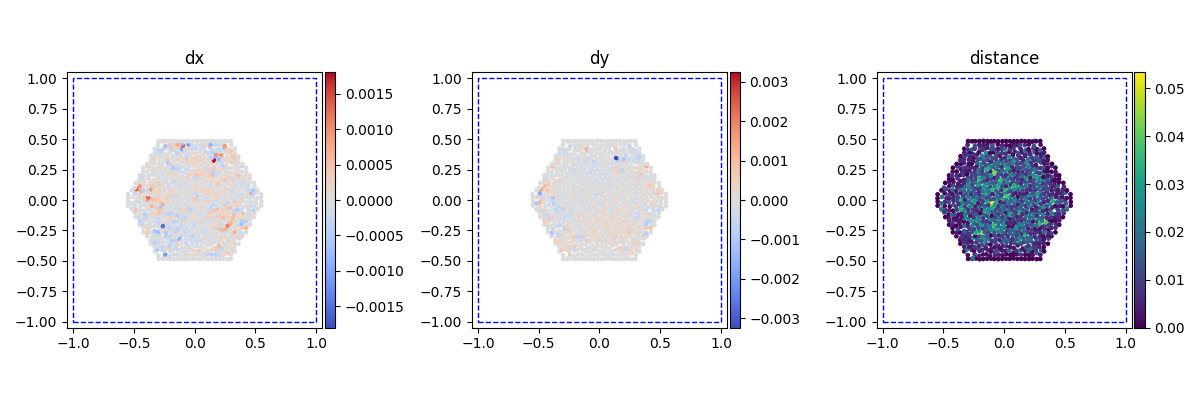

In [171]:
pNoisyCurrent = torch.clone(pNoisy)
for si in range(32):
    numParticles = pNoisyCurrent.shape[0]
    BiCG = True
    h2 = 1 * h
    i, j, rij, xij, hij, Wij, gradWij = neighborSearch(pNoisyCurrent, pNoisyCurrent, h2, h2, kernel = k, dim = dim, periodic = periodic, minDomain = domainMin, maxDomain = domainMax)

    K, J, H = evalKernel(rij, xij, hij, k, dim)

    rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, particles.shape[0], operation = 'interpolate')

    omega = areas / rho

    L, normalizationMatrices, lambdas = computeNormalizationMatrices(pNoisyCurrent, areas, rho, i, j, Wij, gradWij, rij, xij, hij, numParticles)
    n, lMin = computeNormals(pNoisyCurrent, lambdas, areas, ones, rho, i, j, Wij, gradWij, xij, rij, hij, particles.shape[0], L)
    fs, cA, cB = detectFreeSurfaceMaronne(n, i, j, rij, xij, hij, pNoisyCurrent, supports, numParticles, periodic = True, domainMin = domainMin, domainMax = domainMax)
    fs2, colorField, gradColorField = detectFreeSurfaceUsingColorFieldGradient(h2*10, areas, rho, ones, i, j, Wij, gradWij, xij, rij, hij, particles, numParticles)

    fsm = expandFreeSurfaceMask(fs, i, j, numParticles)

    iMasked = i[fs[i] < 0.5]
    jMasked = j[fs[i] < 0.5]
    maskedCount = (fs[i] < 0.5).shape[0]

    # print(J.shape, H.shape)

    J = scatter_sum(J * omega[j,None], i, dim = 0, dim_size = numParticles)
    H = H * omega[j,None,None]
    # print(J.shape, H.shape)

    B = torch.zeros(J.shape[0] * 2, dtype = torch.float32)

    J2 = torch.zeros(J.shape[0], 2, dtype = torch.float32)
    J2[fs < 0.5, :] = J[fs < 0.5, :]

    B[::2] = J2[:,0]
    B[1::2] = J2[:,1]
    x0 = torch.rand(J.shape[0] * 2).to(p.device).type(p.dtype) * h / 4 - h / 8

    x0 = x0.view(-1,2)
    x0[fs > 0.5,0] = 0
    x0[fs > 0.5,1] = 0
    x0 = x0.flatten()

    # print(iMasked.shape, jMasked.shape)

    # x0[fs[i] >= 0.5, 0] = 0

    if BiCG:
        xk = BiCGStab(H[fs[i] < 0.5], B, x0, iMasked, jMasked)
    else:
        xk = LinearCG(H[fs[i] < 0.5], B, x0, iMasked, jMasked)
    # print(f'xk: {xk} ({xk.shape})')
    update =  torch.vstack((-xk[::2],-xk[1::2])).T# , J, H, B

    # print(pNoisy.shape)
    # print(xk.shape)
    # print(update.shape)

    update = torch.clamp(update, -0.5 * h, 0.5 * h)

    # print(torch.diag_embed(torch.ones_like(pNoisyCurrent)).shape)

    n = torch.nn.functional.normalize(gradColorField, dim = -1)
    diag = torch.diag_embed(torch.ones_like(pNoisyCurrent)) - torch.einsum('ij, ik -> ijk', n, n)

    # print(diag.shape, update.shape)

    
    result = update - torch.einsum('ij,ij->i', update, n)[:, None] * n

    # result = torch.bmm(diag, update.unsqueeze(-1)).squeeze(-1)
    # update[fsm > 0.5] = 0.25 * update[fsm > 0.5] * 0
    update[fsm > 0.5] = 0.25 * result[fsm > 0.5]
    update[fs > 0.5] = 0

    # print(diag)

    pNoisyCurrent = pNoisyCurrent + update * 0.5

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

scatterPlotSymmetric(fig, axis[0,0], pNoisyCurrent, update[:,0], domainMin, domainMax, 'dx')
scatterPlotSymmetric(fig, axis[0,1], pNoisyCurrent, update[:,1], domainMin, domainMax, 'dy')
scatterPlot(fig, axis[0,2], pNoisyCurrent, torch.linalg.norm(pNoisyCurrent - pNoisy, dim = -1), domainMin, domainMax, 'distance')
# quiver = axis[0,2].quiver(pNoisyCurrent[:,0], pNoisyCurrent[:,1], (pNoisyCurrent - pNoisy)[:,0], (pNoisyCurrent - pNoisy)[:,1], color = 'black')
# quiver = axis[0,2].quiver(pNoisy[:,0], pNoisy[:,1], n[:,0], n[:,1], color = 'purple', scale = 10)

fig.tight_layout()

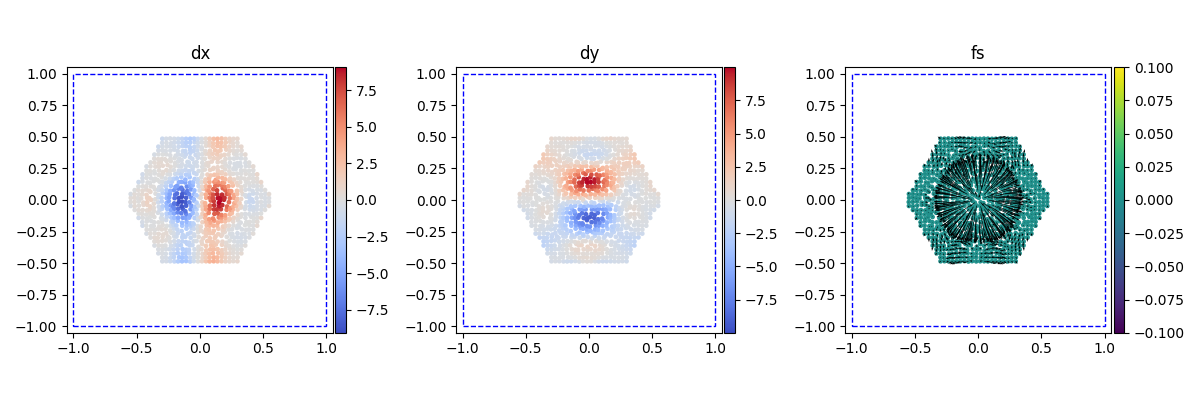

In [162]:
pNoisyCurrent = torch.clone(pNoisy)
i, j, rij, xij, hij, Wij, gradWij = neighborSearch(pNoisyCurrent, pNoisyCurrent, h2, h2, kernel = k, dim = dim, periodic = periodic, minDomain = domainMin, maxDomain = domainMax)

fs2, colorField, gradColorField = detectFreeSurfaceUsingColorFieldGradient(h*10, areas, rho, ones, i, j, Wij, gradWij, xij, rij, hij, particles, numParticles)

L, normalizationMatrices, lambdas = computeNormalizationMatrices(pNoisyCurrent, areas, rho, i, j, Wij, gradWij, rij, xij, hij, numParticles)
n, lMin = computeNormals(pNoisyCurrent, lambdas, areas, ones, rho, i, j, Wij, gradWij, xij, rij, hij, particles.shape[0], L)
    
fs2, cA, cB = detectFreeSurfaceMaronne(n, i, j, rij, xij, hij, pNoisyCurrent, supports, numParticles, periodic = True, domainMin = domainMin, domainMax = domainMax)
    


fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

scatterPlotSymmetric(fig, axis[0,0], pNoisyCurrent, gradColorField[:,0], domainMin, domainMax, 'dx')
scatterPlotSymmetric(fig, axis[0,1], pNoisyCurrent, gradColorField[:,1], domainMin, domainMax, 'dy')
scatterPlot(fig, axis[0,2], pNoisy, fs2, domainMin, domainMax, 'fs')
quiver = axis[0,2].quiver(pNoisyCurrent[:,0], pNoisyCurrent[:,1], gradColorField[:,0], gradColorField[:,1], scale = 100)

fig.tight_layout()
